<a href="https://colab.research.google.com/github/davetew/Modern-Aerospace-Propulsion/blob/main/Inlet_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Inlet Model
This notebook contains an axisymmetric Euler code developed (with the aid of ChatGPT 5.0) intend to facilitate the modeling of an axisymmetric aircraft engine inlet.

In [3]:
# Import the required packages
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
import seaborn as sns

import logging
import os
import time

## Compressible Flow Relations

In [4]:
# Handy compressible flow relations

# Function of the ratio of specific heats
γ1 = lambda γ: γ / (γ-1)

# Ratio of total to static temperature
Tt_T = lambda Mach, γ=1.4: 1 + (γ-1)/2*Mach**2

# Ratio of total to static pressure
Pt_p = lambda Mach, γ=1.4: Tt_T(Mach, γ)**(γ1(γ))

# Ratio of total to static density
ρt_ρ = lambda Mach, γ=1.4: Tt_T(Mach, γ)**(1/γ1(γ))

## Normal Shock Relations

In [5]:
class normal_shock:
  """Class to facilitate the modeling of normal shocks in calorically perfect gases"""

  def __init__(self, Mach_inflow, gamma=1.4):
    self.Mach_inflow = Mach_inflow
    self.ga = gamma

  @property
  def Mach_outflow(self):
    return  np.sqrt((self.Mach_inflow**2 + 2/(self.ga-1))/(2*self.ga/(self.ga-1)*self.Mach_inflow**2-1))

  @property
  def static_pressure_ratio(self):
    return self.Mach_inflow / self.Mach_outflow *np.sqrt(Tt_T(self.Mach_inflow, self.ga)/Tt_T(self.Mach_outflow, self.ga))

  @property
  def static_temperature_ratio(self):
    return Tt_T(self.Mach_inflow, self.ga)/Tt_T(self.Mach_outflow, self.ga)

  @property
  def total_pressure_ratio(self):
    return Pt_p(self.Mach_outflow, self.ga)/Pt_p(self.Mach_inflow, self.ga)

In [6]:
class oblique_shock:
    """Class to facilitate the modeling of oblique shocks in calorically perfect gases"""

    def __init__(self, Mach_inflow, theta, gamma=1.4):
        """
        Args:
            Mach_inflow (float): Inflow Mach number.
            theta (float): Wedge angle in degrees.
            gamma (float, optional): Ratio of specific heats. Defaults to 1.4.
        """
        self.Mach_inflow = Mach_inflow
        self.theta_rad = np.deg2rad(theta)
        self.gamma = gamma

    def beta_finder(self):
        """Finds the shock angle (beta) in degrees for a given inflow Mach number and wedge angle."""
        theta = self.theta_rad
        M1 = self.Mach_inflow
        gamma = self.gamma

        # Define the function to find beta
        def f(beta):
            beta_rad = np.deg2rad(beta)
            return 2.0 / np.tan(theta) * (M1**2 * np.sin(beta_rad)**2 - 1.0) / (M1**2 * (gamma + np.cos(2.0 * beta_rad)) + 2.0) - np.tan(beta_rad)

        # Use a root finder to find beta
        # Need to provide a reasonable range for beta (wedge angle to 90 degrees)
        try:
            from scipy.optimize import fsolve
            beta_guess = np.rad2deg(self.theta_rad + np.arctan(1/M1)) # Initial guess based on Mach angle + theta
            beta_range_start = np.rad2deg(self.theta_rad)
            beta_range_end = 90.0
            beta_solution = fsolve(f, beta_guess)

            # Check if the solution is within a physically meaningful range
            if beta_solution > beta_range_start and beta_solution < beta_range_end:
                 return beta_solution[0]
            else:
                 return np.nan # Return NaN if no valid solution is found

        except ImportError:
            print("Please install SciPy to use the beta_finder method (`pip install scipy`).")
            return np.nan
        except Exception as e:
            print(f"An error occurred during beta calculation: {e}")
            return np.nan

    @property
    def beta(self):
        """Shock angle in degrees."""
        return self.beta_finder()

    @property
    def Mach_inflow_normal(self):
        """Inflow Mach number normal to the shock."""
        return self.Mach_inflow * np.sin(np.deg2rad(self.beta))

    @property
    def Mach_outflow_normal(self):
        """Outflow Mach number normal to the shock."""
        Ms1_sq = self.Mach_inflow_normal**2
        gamma = self.gamma
        return np.sqrt((Ms1_sq + 2/(gamma-1))/(2*gamma/(gamma-1)*Ms1_sq - 1))

    @property
    def Mach_outflow(self):
        """Downstream Mach number."""
        return self.Mach_outflow_normal / np.sin(np.deg2rad(self.beta) - self.theta_rad)

    @property
    def static_pressure_ratio(self):
        """Ratio of static pressure across the shock (p2/p1)."""
        Ms1_sq = self.Mach_inflow_normal**2
        gamma = self.gamma
        return 1 + 2*gamma/(gamma+1) * (Ms1_sq - 1)

    @property
    def static_temperature_ratio(self):
        """Ratio of static temperature across the shock (T2/T1)."""
        Ms1_sq = self.Mach_inflow_normal**2
        gamma = self.gamma
        return (1 + (gamma-1)/2 * Ms1_sq) * (gamma * Ms1_sq + 1) / ((gamma + 1)/2 * Ms1_sq)

    @property
    def static_density_ratio(self):
        """Ratio of static density across the shock (rho2/rho1)."""
        Ms1_sq = self.Mach_inflow_normal**2
        gamma = self.gamma
        return ((gamma+1)*Ms1_sq) / ((gamma-1)*Ms1_sq + 2)

    @property
    def total_pressure_ratio(self):
        """Ratio of total pressure across the shock (Pt2/Pt1)."""
        Ms1_sq = self.Mach_inflow_normal**2
        gamma = self.gamma
        p2_p1 = self.static_pressure_ratio
        rho2_rho1 = self.static_density_ratio
        return (p2_p1 / rho2_rho1)**(gamma/(gamma-1)) * ( (gamma+1)/(gamma*p2_p1/rho2_rho1 + 1) )**(1/(gamma-1))

## Mil Spec Inlet Correlation
This section contains the [NASA Mil Spec](https://www.grc.nasa.gov/www/k-12/airplane/inleth.html) inlet total pressure ratio correlation that is a helpful quick and dirty tool for feasibility studies.

The correlation is a follows--
$$\frac{Pt_{out}}{Pt_{in}} = \eta*\left(1 - 0.075(M_∞-1)^{1.35}\right)$$

$M_\infty$ is the flight Mach number, and $\eta$ is an empirical fitting parameter.

/tmp/ipython-input-3326199755.py:10: RuntimeWarning: invalid value encountered in sqrt
  return  np.sqrt((self.Mach_inflow**2 + 2/(self.ga-1))/(2*self.ga/(self.ga-1)*self.Mach_inflow**2-1))


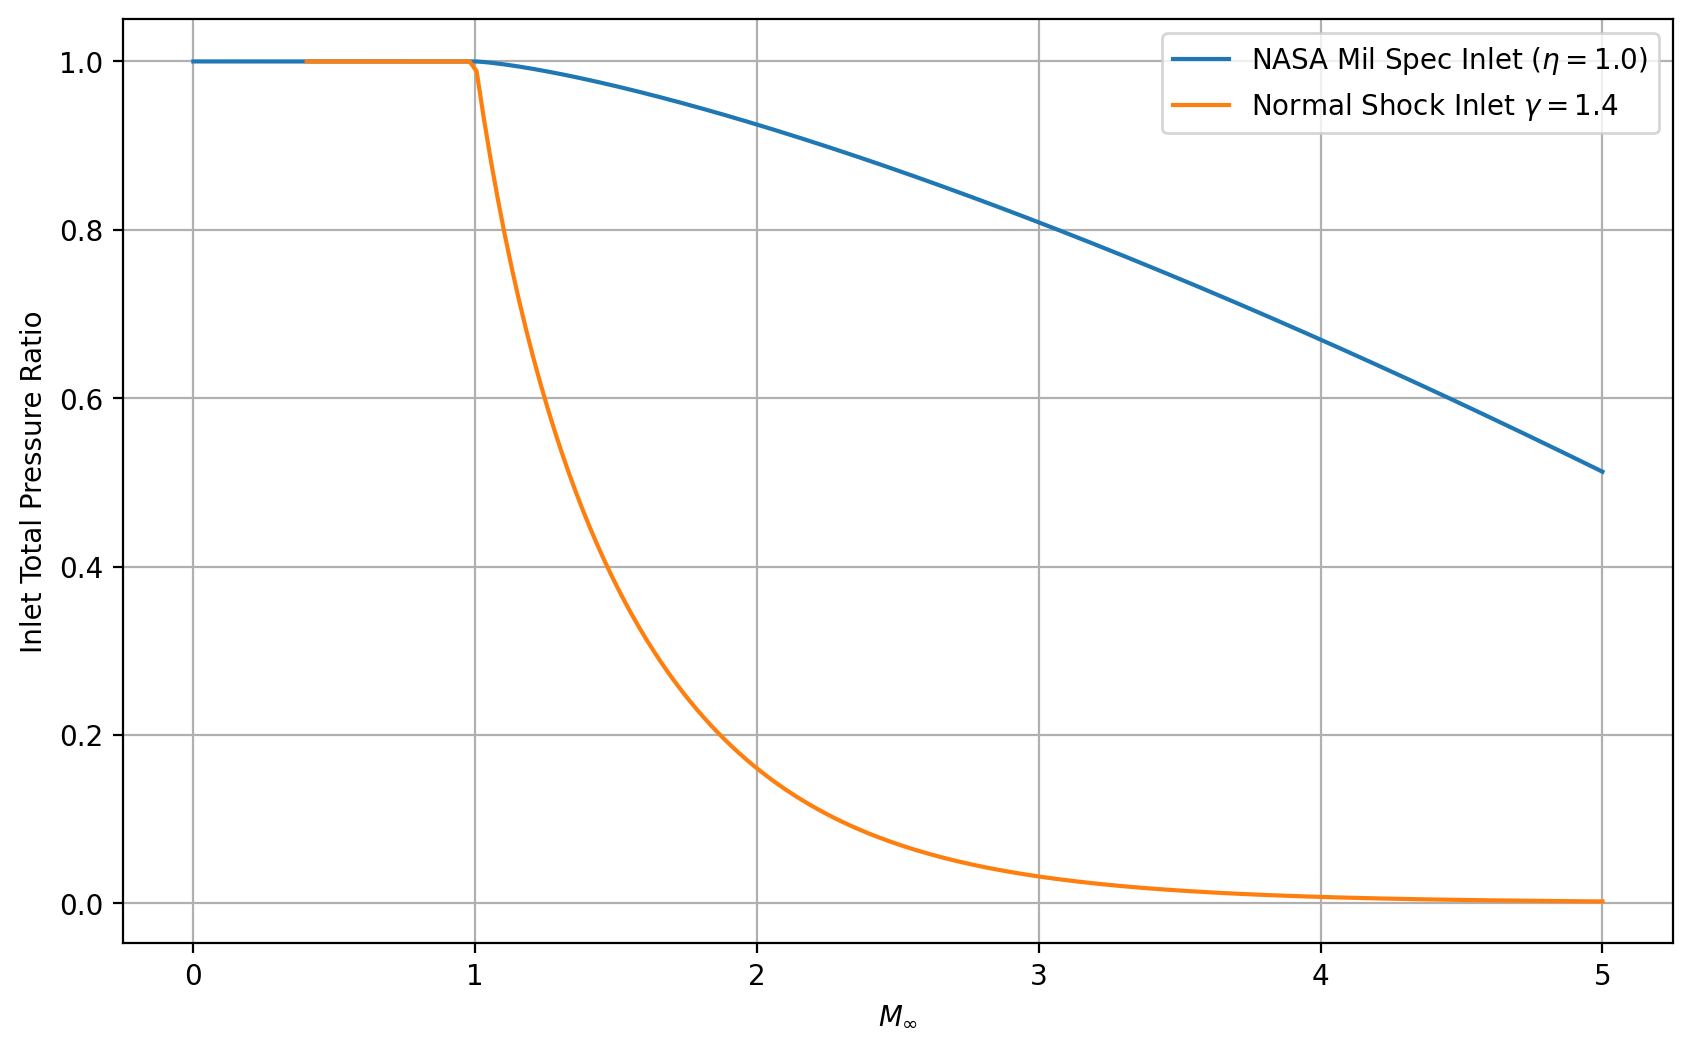

In [ ]:
# NASA Mil Spec inlet total pressure ratio correlation
def nasa_inlet_Ptratio(Mach=None, eta=1.0):
  return (Mach < 1) * eta + (Mach >= 1) * eta * (1 - 0.075 * (np.abs(Mach - 1)) ** 1.35)

def normal_shock_inlet_Ptratio(Mach=None, ga=1.4):
  return (Mach < 1) * 1.0 + (Mach >= 1) * normal_shock(Mach, ga).total_pressure_ratio

# Plot the inlet total pressure ratio versus flight Mach number
Mach = np.linspace(0,5, 200)
fig, ax = plt.subplots(1,1, figsize=(10,6))
ax.plot(Mach, nasa_inlet_Ptratio(Mach), label="NASA Mil Spec Inlet $(\\eta=1.0)$")
ax.plot(Mach, normal_shock_inlet_Ptratio(Mach), label="Normal Shock Inlet $\\gamma=1.4$")
ax.set_xlabel("$M_\\infty$")
ax.set_ylabel("Inlet Total Pressure Ratio")
ax.legend(); ax.grid()
plt.show()

In [7]:
# Example usage of the oblique_shock class
# Define inflow Mach number and wedge angle

M_inflow = 2.5
theta = 10.0  # degrees

# Create an instance of the oblique_shock class
oblique_shock_instance = oblique_shock(Mach_inflow=M_inflow, theta=theta)

# Calculate and print the properties
print(f"Inflow Mach Number: {oblique_shock_instance.Mach_inflow}")
print(f"Wedge Angle (degrees): {np.rad2deg(oblique_shock_instance.theta_rad)}")
print(f"Shock Angle (beta in degrees): {oblique_shock_instance.beta}")
print(f"Outflow Mach Number: {oblique_shock_instance.Mach_outflow}")
print(f"Static Pressure Ratio (p2/p1): {oblique_shock_instance.static_pressure_ratio}")
print(f"Static Temperature Ratio (T2/T1): {oblique_shock_instance.static_temperature_ratio}")
print(f"Static Density Ratio (rho2/rho1): {oblique_shock_instance.static_density_ratio}")
print(f"Total Pressure Ratio (Pt2/Pt1): {oblique_shock_instance.total_pressure_ratio}")

Inflow Mach Number: 2.5
Wedge Angle (degrees): 10.0
Shock Angle (beta in degrees): 31.850592231271996
Outflow Mach Number: 2.0859286654960263
Static Pressure Ratio (p2/p1): 1.8638705181801307
Static Temperature Ratio (T2/T1): 2.2182412717057614
Static Density Ratio (rho2/rho1): 1.5492654769575538
Total Pressure Ratio (Pt2/Pt1): 1.443668533224392


In [ ]:

# axisym_euler.py — Axisymmetric Euler solver for inlet flows (educational reference)



GAMMA = 1.4
EPS = 1e-12

# Basic logger setup (user can configure externally if desired)
def _setup_logger(name="axisym_euler", level=logging.INFO):
    logger = logging.getLogger(name)
    if not logger.handlers:
        logger.setLevel(level)
        ch = logging.StreamHandler()
        ch.setLevel(level)
        fmt = logging.Formatter("[%(asctime)s] %(levelname)s - %(message)s", datefmt="%H:%M:%S")
        ch.setFormatter(fmt)
        logger.addHandler(ch)
    return logger

LOGGER = _setup_logger()

def cons_to_prim(U):
    """Convert conservative variables U = [rho, rho*u, rho*v, rho*E] to primitive variables.
    Returns (rho, u, v, p, a) where a = sqrt(gamma*p/rho) is the speed of sound.
    Numerical safety: density and pressure are clipped to small EPS to avoid negatives.
    Useful when diagnosing non-physical states or checking residuals."""
    rho = U[...,0].clip(EPS, None)
    u = U[...,1]/rho
    v = U[...,2]/rho
    E = U[...,3]/rho
    kin = 0.5*(u*u+v*v)
    p = (GAMMA-1.0)*rho*(E - kin)
    p = p.clip(EPS, None)
    a = np.sqrt(GAMMA*p/rho)
    return rho,u,v,p,a

def prim_to_cons(rho,u,v,p):
    """Convert primitive variables (rho, u, v, p) to conservative form U.
    Energy is computed as E = p/[(gamma-1)rho] + 0.5*(u^2+v^2).
    Used throughout flux/correction steps; keep an eye on p and rho for positivity."""
    E = p/((GAMMA-1.0)*rho) + 0.5*(u*u+v*v)
    U = np.stack([rho, rho*u, rho*v, rho*E], axis=-1)
    return U

def compute_l2_residual(U_prev, U):
    """Compute L2 residual of conservative update (per-component, then max).
    Returns a scalar residual useful for steady convergence monitoring."""
    if U_prev is None:
        return None
    dU = U - U_prev
    dU = np.nan_to_num(dU, nan=0.0, posinf=0.0, neginf=0.0)
    res = np.sqrt(np.mean(dU**2, axis=(0,1)))
    return float(np.max(res))

def nan_killer(U, tag=""):
    """Detect non-finite entries in U and repair in-place by averaging valid neighbors.
    Also dumps a checkpoint .npy for post-mortem. Returns count of repaired cells."""
    nonfinite = ~np.isfinite(U)
    count = int(np.sum(nonfinite))
    if count == 0:
        return 0
    LOGGER.error(f"NaN/Inf detected ({count} entries). Attempting local repair.")
    stamp = time.strftime("%Y%m%d-%H%M%S")
    dump_name = f"dump_U_{tag}_{stamp}.npy" if tag else f"dump_U_{stamp}.npy"
    np.save(dump_name, U)
    U_repair = U.copy()
    for k in range(U.shape[2]):
        F = U[...,k]
        mask = ~np.isfinite(F)
        if not np.any(mask):
            continue
        Fn = np.zeros_like(F)
        W  = np.zeros_like(F)
        for di, dj in [(1,0),(-1,0),(0,1),(0,-1)]:
            Fs = np.roll(F, shift=di, axis=0)
            Fs = np.roll(Fs, shift=dj, axis=1)
            valid = np.isfinite(Fs).astype(Fs.dtype)
            Fn += Fs * valid
            W  += valid
        W = np.where(W>0, W, 1.0)
        F_new = Fn / W
        F[mask] = F_new[mask]
        U_repair[...,k] = F
    rho,u,v,p,a = cons_to_prim(U_repair)
    rho = rho.clip(EPS, None)
    p   = p.clip(EPS, None)
    U_fixed = prim_to_cons(rho, u, v, p)
    U[...] = U_fixed
    LOGGER.info("Local repair applied; continuing.")
    return count

def flux(U, normal):
    """Compute Euler flux in the direction of a unit normal (nx, ny)."""
    nx, ny = normal
    rho,u,v,p,a = cons_to_prim(U)
    un = u*nx + v*ny
    H = (U[...,3] + p) / rho
    F = np.zeros_like(U)
    F[...,0] = rho*un
    F[...,1] = rho*un*u + p*nx
    F[...,2] = rho*un*v + p*ny
    F[...,3] = rho*un*H
    return F, un, a

def sound_speed(U):
    """Return local speed of sound a = sqrt(gamma*p/rho)."""
    rho,u,v,p,a = cons_to_prim(U)
    return a

def hllc_flux(UL, UR, normal):
    """HLLC approximate Riemann solver (vectorized).
    Selects region by masks based on wave speeds SL, S*, SR."""
    nx, ny = normal
    rhoL,uL,vL,pL,aL = cons_to_prim(UL)
    rhoR,uR,vR,pR,aR = cons_to_prim(UR)

    unL = uL*nx + vL*ny
    unR = uR*nx + vR*ny

    pPVRS = 0.5*(pL+pR) - 0.5*(unR-unL)*0.5*(rhoL+rhoR)*0.5*(aL+aR)
    pStar = np.maximum(EPS, pPVRS)

    qL = np.ones_like(pL)
    qR = np.ones_like(pR)
    condL = pStar > pL
    condR = pStar > pR
    qL = np.where(condL, np.sqrt(1.0 + (GAMMA+1.0)/(2.0*GAMMA)*((pStar/pL)-1.0)), qL)
    qR = np.where(condR, np.sqrt(1.0 + (GAMMA+1.0)/(2.0*GAMMA)*((pStar/pR)-1.0)), qR)

    SL = unL - aL*qL  # left-going wave speed estimate
    SR = unR + aR*qR  # right-going wave speed estimate

    rho_bar = 0.5*(rhoL+rhoR)
    a_bar   = 0.5*(aL+aR)
    Sstar_num = pR - pL + rhoL*unL*(SL-unL) - rhoR*unR*(SR-unR)
    Sstar_den = rhoL*(SL-unL) - rhoR*(SR-unR) + 1e-30
    Sstar = Sstar_num/Sstar_den

    FL,_un,_a = flux(UL, normal)
    FR,_un,_a = flux(UR, normal)

    def U_star(U, S, Sstar):
        rho,u,v,p,a = cons_to_prim(U)
        un = u*nx + v*ny
        fac = rho*(S-un)/(S - Sstar + 1e-30)
        tnx = u - un*nx
        tny = v - un*ny
        ustar_n = Sstar
        ustar_x = tnx + ustar_n*nx
        ustar_y = tny + ustar_n*ny
        p_star = p + rho*(S - un)*(Sstar - un)
        return prim_to_cons(fac, ustar_x, ustar_y, p_star)

    Fhllc = np.empty_like(FL)
    A = SL >= 0.0  # all characteristics move to the right: take left flux
    D = SR <= 0.0  # all characteristics move to the left: take right flux
    B = (~A) & (Sstar >= 0.0)
    C = (~A) & (~B) & (~D)
    Fhllc[A] = FL[A]
    if np.any(B):
        ULs = U_star(UL, SL, Sstar)
        Fhllc[B] = FL[B] + SL[B][...,None]*(ULs[B] - UL[B])
    if np.any(C):
        URs = U_star(UR, SR, Sstar)
        Fhllc[C] = FR[C] + SR[C][...,None]*(URs[C] - UR[C])
    Fhllc[D] = FR[D]
    return Fhllc

def muscl_reconstruct(U, axis, limiter='mc'):
    """Second-order MUSCL reconstruction with TVD limiter ('mc' by default).
    axis=0 -> x-faces, axis=1 -> r-faces. Returns (UL_face, UR_face)."""
    def phi_mc(r):
        return np.maximum(0.0, np.minimum( (1.0+2.0*r)/3.0, np.minimum(2.0, 2.0*r) ))
    def phi_minmod(r):
        return np.maximum(0.0, np.minimum(1.0, r))
    phi = phi_mc if limiter=='mc' else phi_minmod
    def shift(arr, k, axis):
        return np.roll(arr, shift=k, axis=axis)
    Um = shift(U, +1, axis)
    Up = shift(U, -1, axis)
    dL = U - Um
    dR = Up - U
    r = np.where(np.abs(dL) > 1e-16, dR/(dL+1e-30), 0.0)
    psi = phi(r)
    slope = psi * dL
    UL = U + 0.5*slope
    UR = U - 0.5*slope
    UL_face = UR
    UR_face = shift(UL, -1, axis)
    return UL_face, UR_face

def apply_wall_slip(U, mask_solid, nxr_unused, dx, dr, x, r):
    """Crude slip wall: assume radial normal (nx=0, ny=1); enforce v=0 inside masked cells."""
    rho,u,v,p,a = cons_to_prim(U)
    un = v  # radial
    u_ref = u
    v_ref = v - un
    U_solid = prim_to_cons(rho, u_ref, v_ref, p)
    U[mask_solid] = U_solid[mask_solid]
    return U

def apply_centerline_symmetry(U):
    """Centerline symmetry handled in step(); placeholder for extensibility."""
    return U

def step(U, dx, dr, dt, mask_solid, x, r):
    """One RK2 step with MUSCL+HLLC and axisymmetric sources."""
    Nx, Nr, _ = U.shape
    ULx, URx = muscl_reconstruct(U, axis=0, limiter='mc')
    ULr, URr = muscl_reconstruct(U, axis=1, limiter='mc')
    Fx = hllc_flux(ULx, URx, (1.0,0.0))
    Fr = hllc_flux(ULr, URr, (0.0,1.0))
    dFdx = (np.roll(Fx, -1, axis=0) - Fx)/dx
    dFrdr = (np.roll(Fr, -1, axis=1) - Fr)/dr

    rho,u,v,p,a = cons_to_prim(U)
    r_mat = r[None,:]
    invr = np.where(r_mat>1e-12, 1.0/r_mat, 0.0)
    S = np.zeros_like(U)
    S[...,0] = - (rho*v) * invr
    S[...,1] = - (rho*u*v) * invr
    S[...,2] = (p - rho*v*v) * invr
    S[...,3] = - ((rho*(0.5*(u*u+v*v)) + p/(GAMMA-1.0) + p)*v) * invr

    R = -(dFdx + dFrdr) + S
    U1 = U + dt*R

    rho1,u1,v1,p1,a1 = cons_to_prim(U1)
    U1 = prim_to_cons(rho1.clip(EPS,None), u1, v1, p1.clip(EPS,None))
    U1[:,0,:] = U1[:,1,:]
    rho_c,u_c,v_c,p_c,a_c = cons_to_prim(U1)
    v_c[:,0] = 0.0
    U1[:,0,:] = prim_to_cons(rho_c[:,0], u_c[:,0], v_c[:,0], p_c[:,0])
    U1 = apply_wall_slip(U1, mask_solid, None, dx, dr, x, r)

    ULx, URx = muscl_reconstruct(U1, axis=0, limiter='mc')
    ULr, URr = muscl_reconstruct(U1, axis=1, limiter='mc')
    Fx = hllc_flux(ULx, URx, (1.0,0.0))
    Fr = hllc_flux(ULr, URr, (0.0,1.0))
    dFdx = (np.roll(Fx, -1, axis=0) - Fx)/dx
    dFrdr = (np.roll(Fr, -1, axis=1) - Fr)/dr

    rho1,u1,v1,p1,a1 = cons_to_prim(U1)
    r_mat = r[None,:]
    invr = np.where(r_mat>1e-12, 1.0/r_mat, 0.0)
    S1 = np.zeros_like(U1)
    S1[...,0] = - (rho1*v1) * invr
    S1[...,1] = - (rho1*u1*v1) * invr
    S1[...,2] = (p1 - rho1*v1*v1) * invr
    S1[...,3] = - ((rho1*(0.5*(u1*u1+v1*v1)) + p1/(GAMMA-1.0) + p1)*v1) * invr

    R1 = -(dFdx + dFrdr) + S1
    U2 = 0.5*(U + U1 + dt*R1)

    rho2,u2,v2,p2,a2 = cons_to_prim(U2)
    U2 = prim_to_cons(rho2.clip(EPS,None), u2, v2, p2.clip(EPS,None))
    U2[:,0,:] = U2[:,1,:]
    rho2,u2,v2,p2,a2 = cons_to_prim(U2)
    v2[:,0] = 0.0
    U2[:,0,:] = prim_to_cons(rho2[:,0], u2[:,0], v2[:,0], p2[:,0])
    U2 = apply_wall_slip(U2, mask_solid, None, dx, dr, x, r)
    return U2

def compute_dt(U, dx, dr, CFL=0.5):
    """Global explicit time-step from CFL with scalar dx, dr."""
    rho,u,v,p,a = cons_to_prim(U)
    lamx = np.abs(u) + a
    lamr = np.abs(v) + a
    inv_dt = lamx/np.maximum(dx,1e-30) + lamr/np.maximum(dr,1e-30)
    max_inv_dt = np.max(inv_dt)
    return CFL / (max_inv_dt + 1e-30)

def characteristic_inlet(Ucol, M_infty, Tt, pt, alpha, a_ref=1.0):
    """Build inlet ghost column from totals (pt,Tt) and target Mach M_infty."""
    Nr = Ucol.shape[0]
    gamma=GAMMA
    R = 287.05
    T = Tt/(1.0 + 0.5*(gamma-1.0)*M_infty*M_infty)
    p_static = pt / (1.0 + 0.5*(gamma-1.0)*M_infty*M_infty)**(gamma/(gamma-1.0))
    a_local = np.sqrt(gamma*R*T)
    V = M_infty*a_local
    ux = V*np.cos(alpha)
    ur = V*np.sin(alpha)
    rho_static = p_static/(R*T)
    rho = np.full((Nr,), rho_static)
    u = np.full((Nr,), ux)
    v = np.full((Nr,), ur)
    p = np.full((Nr,), p_static)
    return prim_to_cons(rho, u, v, p)

def apply_farfield_inlet_outlet(U, i_ghost, jmax, kind, params):
    """1-cell-thick inlet/outlet treatment in x."""
    if kind=='inlet':
        M, Tt, pt, alpha = params['M'], params['Tt'], params['pt'], params.get('alpha',0.0)
        U[i_ghost,:,:] = characteristic_inlet(U[i_ghost+1,:,:], M, Tt, pt, alpha)
    elif kind=='outlet':
        p_back = params['p_back']
        rho_o,u_o,v_o,p_o,a_o = cons_to_prim(U)
        U[i_ghost,:,:] = U[i_ghost-1,:,:]
        pmix = 0.5*p_o[i_ghost,:] + 0.5*p_back
        U[i_ghost,:,:] = prim_to_cons(rho_o[i_ghost,:], u_o[i_ghost,:], v_o[i_ghost,:], pmix)
    return U

def make_levelset_cowl(x, r, R_highlight=0.85, lip_radius=0.08, throat_expansion=1.12, duct_len=0.8):
    """Level-set for a lip + diffuser inner nacelle surface; returns boolean mask (solid=True)."""
    X, R = np.meshgrid(x, r, indexing='xy')
    x0 = 0.15
    r0 = R_highlight + lip_radius
    phi_lip = np.sqrt( (X-x0)**2 + (R - r0)**2 ) - lip_radius
    x_aip = x0 + duct_len
    inner_r_at_lip = R_highlight
    inner_r_aip = inner_r_at_lip*throat_expansion
    slope = (inner_r_aip - inner_r_at_lip)/max(x_aip - x0, 1e-6)
    r_inner_line = np.where(X>=x0, inner_r_at_lip + slope*(X-x0), 1e9)
    phi_diffuser = R - r_inner_line
    phi = np.minimum(phi_lip, phi_diffuser)
    mask_solid = (phi < 0.0)
    return mask_solid

def compute_recovery(U, r, x_index, pt_inf):
    """Area-weighted (∝ r) total-pressure recovery at axial index x_index: <pt>_AIP / pt_inf."""
    rho,u,v,p,a = cons_to_prim(U)
    Vmag = np.sqrt(u*u+v*v)
    M = Vmag/(a+1e-30)
    pt = p * (1.0 + 0.5*(GAMMA-1.0)*M*M)**(GAMMA/(GAMMA-1.0))
    w = r.copy()
    w[0] = 0.0
    num = np.sum(pt[x_index,:]*w)
    den = np.sum(w) + 1e-30
    pt_bar = num/den
    return pt_bar/pt_inf

def run_pitot_case(Nx=240, Nr=120, M_inf=0.6, Tt=300.0, pt=None,
                   xlen=1.2, rmax=1.2, R_highlight=0.85, lip_radius=0.08, throat_expansion=1.12, duct_len=0.8,
                   p_back_frac=1.0, max_steps=2000, CFL=0.45, output_every=200,
                   log_every=50, chkpt_every=0, enable_nan_killer=True):
    """Top-level driver for a pitot-style, subsonic inlet case.
    Extra controls:
    - log_every: print field statistics and residual every N iterations.
    - chkpt_every: save checkpoint_U_itXXXX.npy every N iterations (0 = off).
    - enable_nan_killer: automatically repair NaN/Inf and dump a snapshot for post-mortem."""
    if pt is None:
        pt = 101325.0*(1.0+0.5*(GAMMA-1.0)*M_inf*M_inf)**(GAMMA/(GAMMA-1.0))
    # Grid
    x = np.linspace(0.0, xlen, Nx+2)
    r = np.linspace(0.0, rmax, Nr+1)
    dx_arr = (x[1:] - x[:-1])
    dr_arr = (r[1:] - r[:-1])
    dx_cell = float(np.mean(dx_arr[1:-1]))
    dr_cell = float(np.mean(dr_arr))

    Xc = 0.5*(x[1:]+x[:-1])
    Rc = 0.5*(r[1:]+r[:-1])

    gamma=GAMMA; Rgas=287.05
    T = Tt/(1.0 + 0.5*(gamma-1.0)*M_inf*M_inf)
    p_static = pt / (1.0 + 0.5*(gamma-1.0)*M_inf*M_inf)**(gamma/(gamma-1.0))
    a = np.sqrt(gamma*Rgas*T)
    V = M_inf*a
    rho = p_static/(Rgas*T)
    U = np.zeros((Nx, Nr, 4))
    U[...,0] = rho
    U[...,1] = rho*V
    U[...,2] = 0.0
    E = p_static/((gamma-1.0)*rho) + 0.5*(V*V)
    U[...,3] = rho*E

    mask_solid = make_levelset_cowl(Xc, Rc, R_highlight, lip_radius, throat_expansion, duct_len).T
    mask_solid = mask_solid[:Nx, :Nr]

    pt_inf = pt
    p_back = p_static * p_back_frac
    history = []
    U_prev = None
    last_chkpt = 0

    for n in range(1, max_steps+1):
        dt = compute_dt(U, dx_cell, dr_cell, CFL=CFL)

        # Simple residual & stats
        res = compute_l2_residual(U_prev, U)
        if (n % log_every == 0) or (n == 1):
            rho_,u_,v_,p_,a_ = cons_to_prim(U)
            M_ = np.sqrt(u_*u_+v_*v_)/(a_+1e-30)
            LOGGER.info(f"it={n:5d}  dt={dt:.3e}  CFL={CFL:.2f}  res={None if res is None else f'{res:.3e}'}  "
                        f"min/max rho=({np.nanmin(rho_):.3e},{np.nanmax(rho_):.3e})  "
                        f"min/max p=({np.nanmin(p_):.3e},{np.nanmax(p_):.3e})  "
                        f"min/max M=({np.nanmin(M_):.3e},{np.nanmax(M_):.3e})")

        # Optional checkpointing
        if chkpt_every and (n - last_chkpt >= chkpt_every):
            np.save(f"checkpoint_U_it{n}.npy", U)
            last_chkpt = n

        # NaN/Inf guard
        if enable_nan_killer:
            repaired = nan_killer(U, tag=f"it{n}")
            if repaired > 0:
                LOGGER.warning(f"Repaired {repaired} non-finite entries at iteration {n}")

        # Ghost columns
        U_ext = np.zeros((Nx+2, Nr, 4))
        U_ext[1:-1,:,:] = U
        U_ext = apply_farfield_inlet_outlet(U_ext, i_ghost=0, jmax=Nr, kind='inlet',
                                            params={'M':M_inf, 'Tt':Tt, 'pt':pt, 'alpha':0.0})
        U_ext = apply_farfield_inlet_outlet(U_ext, i_ghost=Nx+1, jmax=Nr, kind='outlet',
                                            params={'p_back':p_back})

        # Update
        U = step(U_ext[1:-1,:,:], dx_cell, dr_cell, dt, mask_solid, Xc, Rc)

        # Keep previous for residual
        U_prev = U.copy()

        if n % output_every == 0 or n==1:
            rec = compute_recovery(U, Rc, x_index=min(Nx-2, int(0.15*Nx)+int(duct_len/xlen*Nx)), pt_inf=pt_inf)
            history.append((n, rec))
            LOGGER.info(f"AIP recovery ~ {rec:.5f} at iteration {n}")

    return U, Xc, Rc, mask_solid, np.array(history)


[16:45:13] INFO - it=    1  dt=1.415e-06  CFL=0.20  res=None  min/max rho=(1.261e+00,1.261e+00)  min/max p=(1.013e+05,1.013e+05)  min/max M=(6.000e-01,6.000e-01)
INFO:axisym_euler:it=    1  dt=1.415e-06  CFL=0.20  res=None  min/max rho=(1.261e+00,1.261e+00)  min/max p=(1.013e+05,1.013e+05)  min/max M=(6.000e-01,6.000e-01)
[16:45:13] INFO - AIP recovery ~ 1.00000 at iteration 1
INFO:axisym_euler:AIP recovery ~ 1.00000 at iteration 1
[16:45:14] INFO - it=   10  dt=1.413e-06  CFL=0.20  res=0.000e+00  min/max rho=(1.261e+00,1.262e+00)  min/max p=(1.012e+05,1.014e+05)  min/max M=(5.999e-01,6.003e-01)
INFO:axisym_euler:it=   10  dt=1.413e-06  CFL=0.20  res=0.000e+00  min/max rho=(1.261e+00,1.262e+00)  min/max p=(1.012e+05,1.014e+05)  min/max M=(5.999e-01,6.003e-01)
[16:45:15] INFO - it=   20  dt=1.407e-06  CFL=0.20  res=0.000e+00  min/max rho=(1.254e+00,1.268e+00)  min/max p=(1.005e+05,1.021e+05)  min/max M=(5.959e-01,6.035e-01)
INFO:axisym_euler:it=   20  dt=1.407e-06  CFL=0.20  res=0.000e+

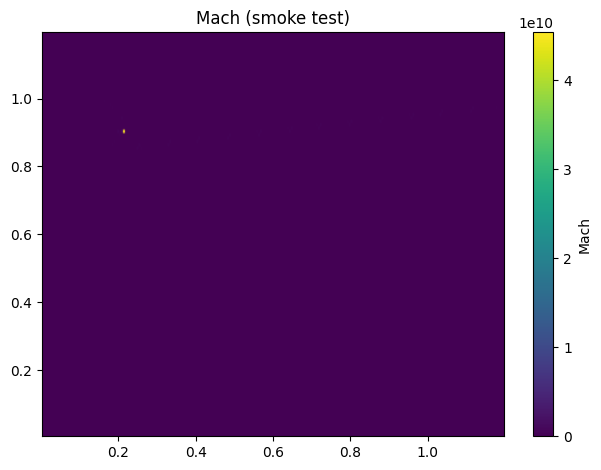

In [ ]:
  # Small smoke test (short run) to ensure code paths work; not a replacement for full cases.
  U,Xc,Rc,mask,hist = run_pitot_case(max_steps=50, output_every=25, log_every=10, chkpt_every=25, CFL=0.2)
  rho,u,v,p,a = cons_to_prim(U)
  M = np.sqrt(u*u+v*v)/(a+1e-30)
  import matplotlib.pyplot as plt
  plt.figure()
  plt.imshow(M.T, origin='lower', extent=[Xc[0], Xc[-1], Rc[0], Rc[-1]], aspect='auto')
  plt.colorbar(label='Mach')
  plt.title('Mach (smoke test)')
  plt.tight_layout()
  plt.savefig('smoketest_mach.png', dpi=120)

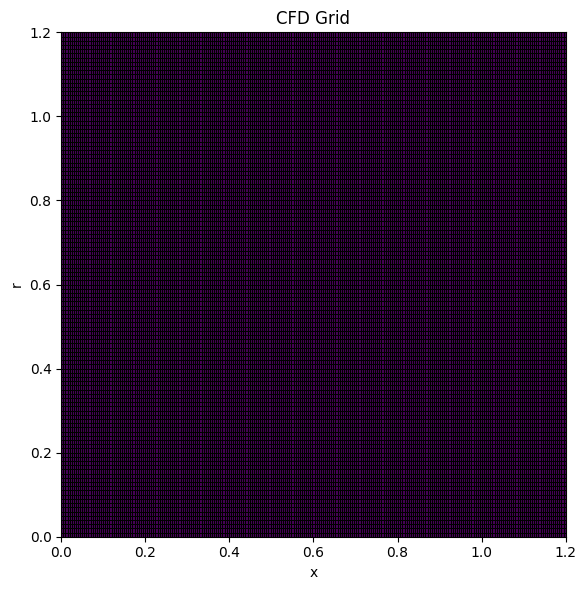

In [ ]:
# Plot the grid using pcolormesh
plt.figure(figsize=(8, 6))

# Calculate cell corner coordinates
x_corners = np.concatenate([Xc - 0.5*(Xc[1]-Xc[0]), [Xc[-1] + 0.5*(Xc[-1]-Xc[-2])]])
r_corners = np.concatenate([Rc - 0.5*(Rc[1]-Rc[0]), [Rc[-1] + 0.5*(Rc[-1]-Rc[-2])]])

# Create a dummy data array with dimensions one smaller than corner coordinates
dummy_data = np.zeros((Rc.shape[0], Xc.shape[0]))

plt.pcolormesh(x_corners, r_corners, dummy_data, cmap='viridis', shading='flat', edgecolors='k', linewidth=0.5)
# plt.colorbar(label='Value') # We are just visualizing the grid, no need for colorbar
plt.title('CFD Grid')
plt.xlabel('x')
plt.ylabel('r')
plt.gca().set_aspect('equal', adjustable='box') # Ensure equal aspect ratio
plt.tight_layout()
plt.show()